# This notebook is for the practice purpose for my data science skill

Here, all about the needed basic skill of EDA and basic modeling along with visualization along various interactive libraries like plotly, altair, seaborn and so on will be done


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


# 1. Import all necessary packages

In [3]:
#Import packages
import pandas as pd
import numpy as np
from collections import Counter

#For visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt


#For other models
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from kmodes.kmodes import KModes
from kmodes import kprototypes

#Calculate distance matrix to cluster mixed data type
from scipy.spatial import distance_matrix

#For calculate solhouette_score
from sklearn.metrics import silhouette_score

#For Encoding
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder


# For metrics and helpful functions
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

#warning
import warnings

In [4]:
warnings.filterwarnings("ignore") # To prevent kernel from showing any warning

# 2. Load Dataset

In [5]:
#Load dataset
df = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')
#Display first 10 rows of dataset
df.head(10)

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40
5,6,Female,22,17,76
6,7,Female,35,18,6
7,8,Female,23,18,94
8,9,Male,64,19,3
9,10,Female,30,19,72


In [6]:
#Rename columns 
df = df.rename(columns={"Annual Income (k$)": "Annual Income", "Spending Score (1-100)": "Spending Score"})
#Display bottom 10 rows 
df.tail(10)

,CustomerID,Gender,Age,Annual Income,Spending Score
190,191,Female,34,103,23
191,192,Female,32,103,69
192,193,Male,33,113,8
193,194,Female,38,113,91
194,195,Female,47,120,16
195,196,Female,35,120,79
196,197,Female,45,126,28
197,198,Male,32,126,74
198,199,Male,32,137,18
199,200,Male,30,137,83


# 3. EDA (Exploratory Data Analysis)

## 3.1 Basic Info 

In [7]:
#Data shape
print(f'There are {df.shape[0]} rows and {df.shape[1]} columns in the data')

There are 200 rows and 5 columns in the data


In [8]:
#dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   CustomerID      200 non-null    int64 
 1   Gender          200 non-null    object
 2   Age             200 non-null    int64 
 3   Annual Income   200 non-null    int64 
 4   Spending Score  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


**Pandas**  is a popular heterogeneous data managing library that hold data in 2 form either in Series or in data frame, heere data is in data frame,it is very much used while manipulation of heterogenous data.

## 3.2 Check for missing and duplicate values

In [9]:
#Check for missing value
df.isna().sum()

CustomerID        0
Gender            0
Age               0
Annual Income     0
Spending Score    0
dtype: int64

In [10]:
#Check for duplicates
df.duplicated().sum()

0

## 3.3 Drop unecessary columns

In [11]:
#Drop `CustomerID` that not need for modeling
clean_df = df.drop(['CustomerID'],axis=1)

clean_df.head(7)

,Gender,Age,Annual Income,Spending Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
5,Female,22,17,76
6,Female,35,18,6


## 3.4 Descriptive statistics about the data

In [12]:
#Display basic descriptive stats
clean_df.describe()

,Age,Annual Income,Spending Score
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


This provide a very general overview of our data that help in the initial phase of data analysis.

## 3.5 Check & Handle outliers

In [13]:
#Create subplot to visualize outliers
fig = px.box(clean_df, y="Annual Income")
fig.show()

**Plotly** is an interactive visualizing app which is used mostly after one get good at visulization knowledge initiated mostly through matplotlib.

This function could be used for the calculation of outliers in the dataset, since we don't have much in our data, which is clearly visible in the box plot.

In [14]:
#Create function to calculate the upper limit, lower limit, number of outliers and their % in dataset for each specified column
def calculate_outliers(df, column_names):
    """
    Calculate upper limit, lower limit, number of outliers and the % in dataset for each specified column .

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data and need to calculate outliers
    - column_names (list): A list of column names to analyze for outliers.

    Returns:
    - pd.DataFrame: A DataFrame containing information about outliers for each specified column.
      Columns: ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit']
    """

    # Calculate the number of columns and rows for subplots
    col_len = len(column_names)
    if col_len % 2 == 0:
      num_columns = 2
      num_rows = col_len // 2
    else:
      num_columns = col_len
      num_rows = 1


    # Initialize a list to store outlier information for each column
    outlier_data = []

    # Iterate over column_names and create subplots
    for i, column_name in enumerate(column_names):
        data = df[column_name]

        # Calculate quartiles and interquartile range using np.percentile
        q1, q3 = np.percentile(data, [25, 75])
        iqr = q3 - q1

        # Define lower and upper limits for outlier detection
        low_lim, upp_lim = q1 - 1.5 * iqr, q3 + 1.5 * iqr

        # Find and display outliers
        outliers = df[(data < low_lim) | (data > upp_lim)][column_name]
        num_outliers = len(outliers)
        percent_outliers = round(num_outliers / len(df) * 100, 1)

        # Append outlier information to the list
        outlier_data.append([column_name, num_outliers, percent_outliers, round(low_lim, 1), round(upp_lim, 1)])


    # Combine the outlier information into a DataFrame
    outlier_df = pd.DataFrame(outlier_data,
                              columns = ['Column', 'Number of Outliers', '% Outliers', 'Lower Limit', 'Upper Limit'])
    return outlier_df

In [15]:
#Define column to check
col=['Annual Income']
#use function `calculate_outliers` to detect and visualize outliers in table
outliers_table = calculate_outliers(clean_df,col)
#Display outliers table
outliers_table

,Column,Number of Outliers,% Outliers,Lower Limit,Upper Limit
0,Annual Income,2,1.0,-13.2,132.8


In [16]:
clean_df['Gender'].value_counts()

Gender
Female    112
Male       88
Name: count, dtype: int64

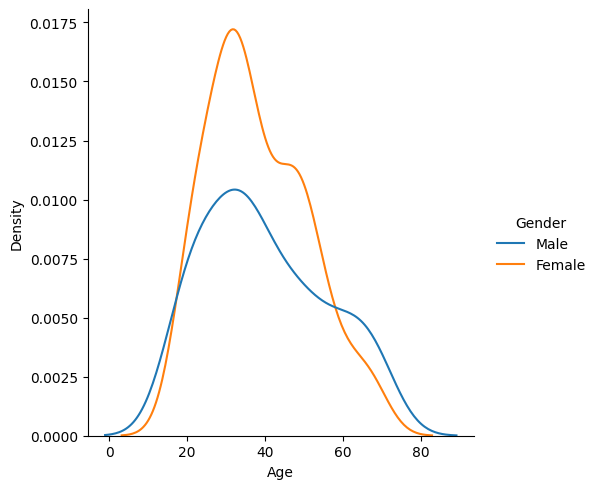

In [17]:
sns.displot(clean_df, x = 'Age',hue='Gender', kind='kde')

In [18]:
#Visulize `Gender` distribution

##Create series to count values in `Gender` column
gender_dis = clean_df['Gender'].value_counts()

##visualize in pie chart
fig = px.pie(
             names=gender_dis.index,
             values= gender_dis.values,
             title='<b>Gender Count</b>',
             hole=.4,
             width=400,
             height=400
             )
fig.update_traces(textposition='inside',
                  textinfo='percent+label+value',
                  textfont_size=15,
                  marker=dict(colors=['#BB2525', '#279EFF'], line=dict(color='#000000', width=2)))
fig.update_layout(title={'font': {'size': 25}}, showlegend=False)
fig.show()

In [19]:
avg_cost = clean_df['Age'].mean().round(0)

fig = px.histogram(
    clean_df, 
    x = 'Age',
    color='Gender',
    # labels={'comb08': "Annual Fuel Cost"},
    nbins=10,
    title='Age Distribution',
    color_discrete_sequence=px.colors.sequential.Magenta_r,
)
fig.add_vline(
    x = avg_cost,
    annotation_text = f'Average {avg_cost}'
)
fig.show()

In [20]:
clean_df.tail()

,Gender,Age,Annual Income,Spending Score
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18
199,Male,30,137,83


In [21]:
avg_cost = clean_df['Annual Income'].mean().round(0)

fig = px.histogram(
    clean_df, 
    x = 'Annual Income',
    color='Gender',
    # labels={'comb08': "Annual Fuel Cost"},
    nbins=10,
    title='Annual Income Distribution',
    color_discrete_sequence=px.colors.sequential.Magenta_r,
)
fig.add_vline(
    x = avg_cost,
    annotation_text = f'Average ${avg_cost}k'
)
fig.show()

In [22]:
df['Annual Income'].max()

137

In [23]:
avg_cost = clean_df['Spending Score'].mean().round(0)

fig = px.histogram(
    clean_df, 
    x = 'Spending Score',
    color='Gender',
    # labels={'comb08': "Annual Fuel Cost"},
    nbins=10,
    title='Spending Score Distribution',
    color_discrete_sequence=px.colors.sequential.Magenta_r,
)
fig.add_vline(
    x = avg_cost,
    annotation_text = f'Average ${avg_cost}k'
)
fig.show()

Based on the data presented in the charts, we can make several key observations:

- The distribution of Annual Income appears to be somewhat normal, with a majority of customers falling within the  $60,000 -  $80,000 range.
- The mall customers majority are under 40 years old.
- The Spending Score also follows a normal distribution pattern.

In [24]:
fig = px.bar(
    clean_df, 
    x = 'Age',
    y = 'Annual Income',
    color='Gender',
)
fig.show()

In [25]:
import plotly.graph_objects as go

fig = px.bar(
    clean_df,
    x='Age',
    y='Annual Income',
    color = 'Gender'
    )

fig.show()

In [26]:
import plotly.graph_objects as go

fig = px.bar(
    clean_df,
    x='Age',
    y='Spending Score',
    color = 'Gender'
    )

fig.show()

In [27]:
fig = px.scatter(
    clean_df,
    x = 'Age',
    y = 'Annual Income',
    trendline='ols'
)
fig.show()

In [28]:
fig = px.scatter(
    clean_df,
    x = 'Age',
    y = 'Annual Income',
    trendline='lowess'
)
fig.show()

In [29]:
clean_df.tail(7)

,Gender,Age,Annual Income,Spending Score
193,Female,38,113,91
194,Female,47,120,16
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18
199,Male,30,137,83


In [30]:
fig = px.sunburst(
    clean_df,
    path = ['Gender', 'Age', 'Annual Income'],
    values='Spending Score'
)

fig.show()

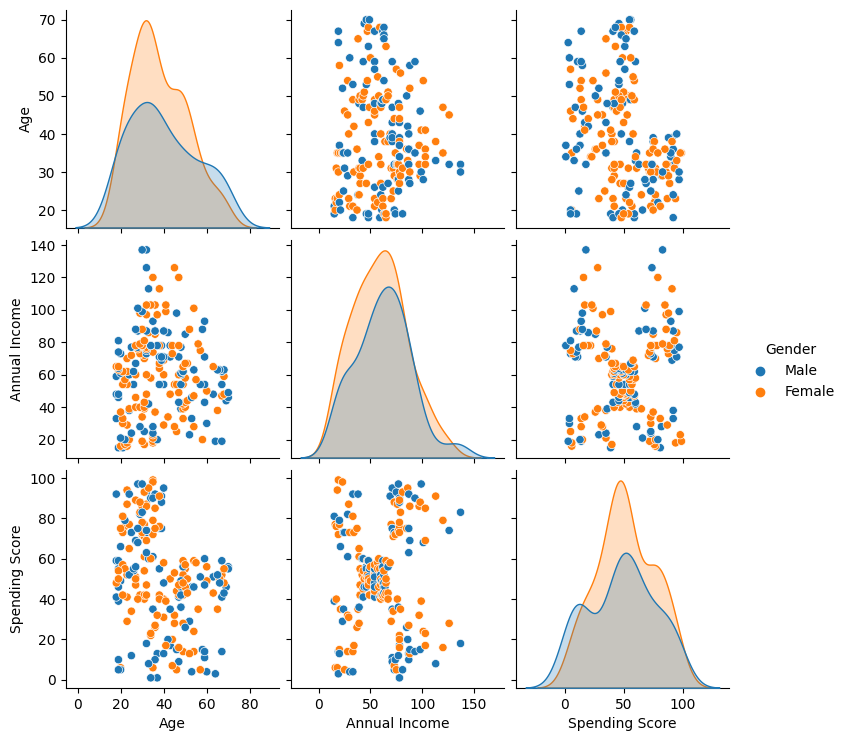

In [31]:
sns.pairplot(clean_df,hue='Gender')

<Axes: >

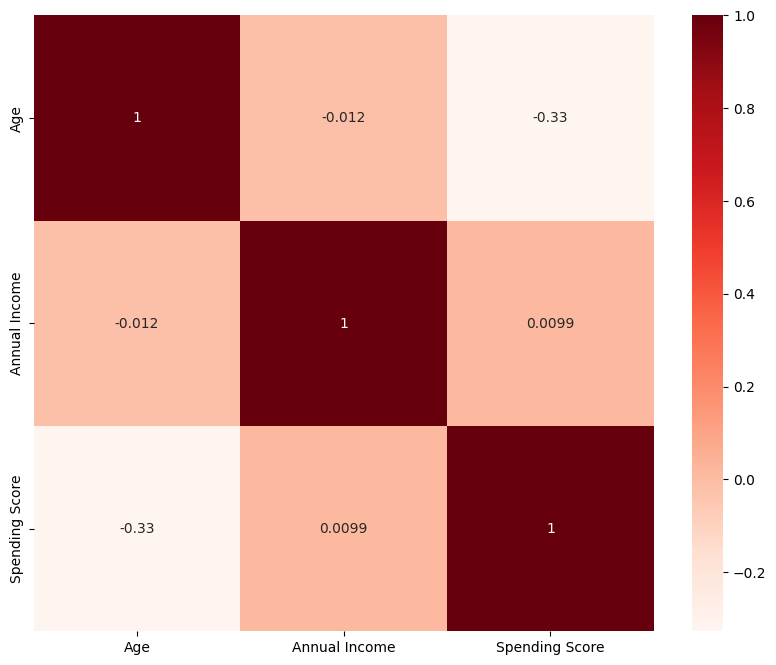

In [32]:
#Create heatmap to check correlation of all numerical features
plt.figure(figsize=(10,8))
sns.heatmap(clean_df.drop('Gender',axis=1).corr(), annot=True, cmap=plt.cm.Reds)

- There is an inverse relationship between Age and both Annual Income and Spending Score, suggesting that as age increases, annual income and spending score tend to decrease.
- Annual Income and Spending Score exhibit a positive correlation, meaning that as annual income increases, spending score also tends to increase.
- Overall, there is no strong correlation observed among the three features, Age, Annual Income, and Spending Score

# 4. Modeling 

In [33]:
#Define number of cluster want to fit and evaluate
num_clusters = [i for i in range(2, 16)]
num_clusters

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

In [34]:
#Create subset dataframe with 2 features: `Annual Income` and `Spending Score`
X_2dim = clean_df[['Annual Income','Spending Score']]

In [35]:
#Standarize the data
X_2dim_scaled = StandardScaler().fit_transform(X_2dim)
#Transform to dataframe
X_2dim_scaled = pd.DataFrame(X_2dim_scaled,columns = X_2dim.columns)
#Double check dataframe
X_2dim_scaled.describe()

,Annual Income,Spending Score
count,2.000000e+02,2.000000e+02
mean,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00
min,-1.738999e+00,-1.910021e+00
25%,-7.275093e-01,-5.997931e-01
50%,3.587926e-02,-7.764312e-03
75%,6.656748e-01,8.851316e-01
max,2.917671e+00,1.894492e+00


In [36]:
#Funtion to fit kmeans and evaluate inertia for different number of cluster

def kmeans_inertia(num_clusters, x_vals):
  """
  Accepts as arguments list of ints and data array.
  Fits a KMeans model where k = each value in the list of ints.

  Parameters:
    - num_clusters: number of cluster will fit and evaluate inertia
    - x_vals: the dataframe need to fit and evaluate inertia

  Returns list of inertia value for each k using KMeans model to fit.
  """
  inertia = []
  for num in num_clusters:
    kms = KMeans(n_clusters=num, random_state=20)
    kms.fit(x_vals)
    inertia.append(kms.inertia_)

  return inertia

In [37]:
#Call kmeans_inertia function to return list of inertia
inertia_2dim = kmeans_inertia(num_clusters,X_2dim)
#Display list of inertia
inertia_2dim

[181363.59595959593,
 106348.37306211119,
 73679.78903948834,
 44448.45544793371,
 37233.81451071001,
 30566.45113025186,
 26127.946449295392,
 21818.114588452183,
 19657.783608703958,
 17577.687828862057,
 15975.067682586232,
 14271.670282658517,
 12747.464279348103,
 11709.803127669433]

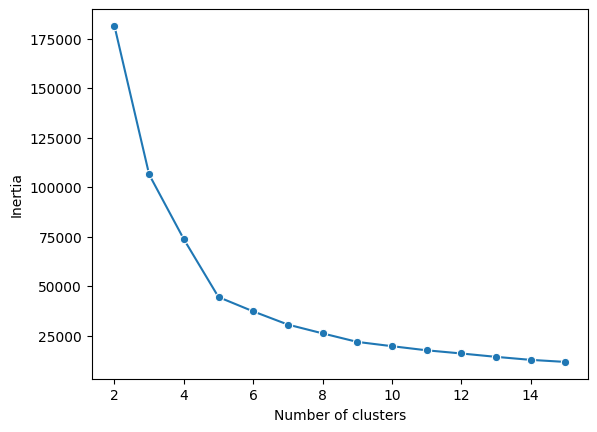

In [38]:
#Create line plot to visualize inertia and number of cluster respectively
plot = sns.lineplot(x=num_clusters, y=inertia_2dim, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

As expected, we can see an 'elbow' clearly at 5 clusters. Next step, we will calculate silhouette score for each cluster in range of num_clusters

In [39]:
#Fit a 5-clusters model
kmeans5_2dim = KMeans(n_clusters=5, n_init='auto', random_state=50)
kmeans5_2dim.fit(X_2dim_scaled)

KMeans(n_clusters=5, n_init='auto', random_state=50)

In [40]:
#Use Counter to count number of data points in each cluster
Counter(kmeans5_2dim.labels_)

Counter({1: 81, 3: 39, 0: 35, 4: 23, 2: 22})

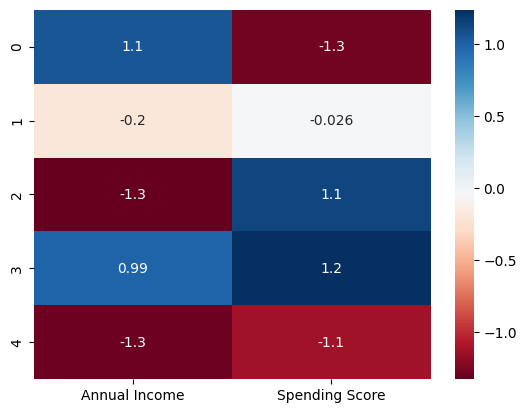

In [41]:
#Create heatmap to visulize cluster center of each cluster
clus_cen5_2dim = pd.DataFrame(kmeans5_2dim.cluster_centers_, columns=X_2dim_scaled.columns)
sns.heatmap(clus_cen5_2dim, cmap='RdBu', annot=True);

As obseration, below are characteristics of 5 clusters:

- Cluster 0: High income but low spending score
- Cluster 1: Average income and average spending score
- Cluster 2: Low income and high spending score
- Cluster 3: High income and high spending score
- Cluster 4: Low income and low spending score

In [42]:
kmeans5_2dim.labels_

array([4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2,
       4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 1,
       4, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 0, 3, 1, 3, 0, 3, 0, 3,
       1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3], dtype=int32)

In [43]:
clean_df['cluster'] = kmeans5_2dim.labels_

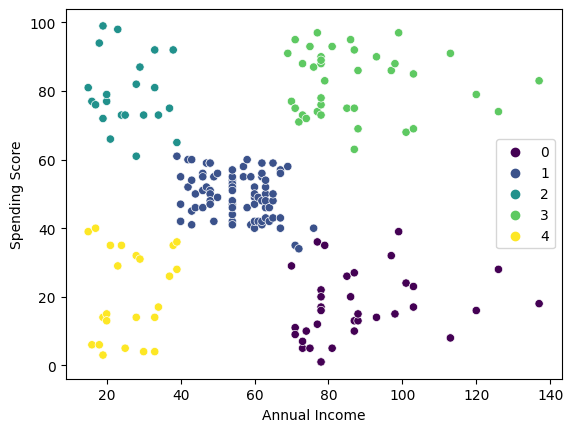

In [44]:
#Create scatterplot to visualize clusters in 2 dimensions
sns.scatterplot(x='Annual Income',
                y='Spending Score',
                hue=kmeans5_2dim.labels_,
                data=clean_df,
                palette='viridis');

In [45]:

fig = px.scatter(clean_df, x="Annual Income", y="Spending Score", color="cluster", symbol="cluster")
fig.show()

In [46]:
fig = px.scatter(clean_df, x="Annual Income", y="Spending Score", color="cluster",
                 size='Spending Score', hover_data=['Spending Score'])
fig.show()

In [47]:
clean_df.tail()

,Gender,Age,Annual Income,Spending Score,cluster
195,Female,35,120,79,3
196,Female,45,126,28,0
197,Male,32,126,74,3
198,Male,32,137,18,0
199,Male,30,137,83,3


In [48]:
#Create dataframe with 2 features: `Annual Income` and `Spending Score`
X_3dim = clean_df.drop('Gender',axis=1)
#Double check dataframe
X_3dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             200 non-null    int64
 1   Annual Income   200 non-null    int64
 2   Spending Score  200 non-null    int64
 3   cluster         200 non-null    int32
dtypes: int32(1), int64(3)
memory usage: 5.6 KB


In [49]:
#Create dataframe with 2 features: `Annual Income` and `Spending Score`
X_3dim = X_3dim.drop('cluster',axis=1)
#Double check dataframe
X_3dim.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             200 non-null    int64
 1   Annual Income   200 non-null    int64
 2   Spending Score  200 non-null    int64
dtypes: int64(3)
memory usage: 4.8 KB


In [50]:
#Standarize the dataframe
X_3dim_scaled = StandardScaler().fit_transform(X_3dim)
#Transform to dataframe
X_3dim_scaled = pd.DataFrame(X_3dim_scaled,columns = X_3dim.columns)
#Double check dataframe
X_3dim_scaled.describe()

,Age,Annual Income,Spending Score
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


In [51]:
##Call kmeans_inertia function to return list of inertia for num_clusters
inertia_3dim = kmeans_inertia(num_clusters, X_3dim_scaled)
inertia_3dim

[389.3861889564372,
 295.2122461555488,
 205.22514747675913,
 168.24758017556834,
 133.88887021131026,
 117.16037738269051,
 104.1276108225113,
 93.18694856084618,
 83.14546210832113,
 72.29635738054932,
 67.65319041794301,
 64.1423714932445,
 60.46898491172401,
 56.2773003720883]

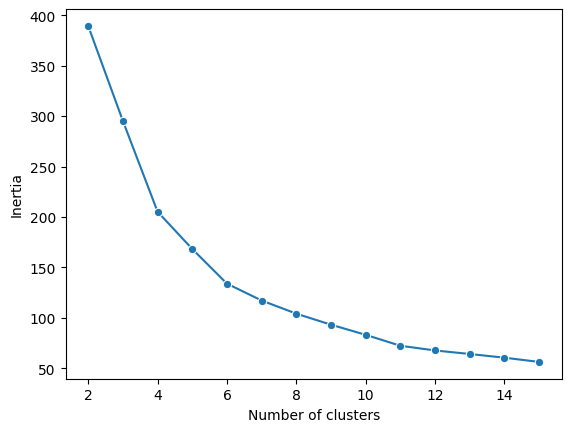

In [52]:
#Create a line plot to visualize internia for each cluster
plot = sns.lineplot(x=num_clusters, y=inertia_3dim, marker = 'o')
plot.set_xlabel("Number of clusters");
plot.set_ylabel("Inertia");

In [53]:
#Fit a 6-cluster model
kmeans6_3dim = KMeans(n_clusters=6,n_init='auto',random_state=50)
kmeans6_3dim.fit(X_3dim_scaled)

KMeans(n_clusters=6, n_init='auto', random_state=50)

In [54]:
#Find the number of data points in each cluster using Counter
Counter(kmeans6_3dim.labels_)

Counter({4: 45, 1: 40, 3: 39, 0: 30, 5: 25, 2: 21})

In [55]:
kmeans6_3dim.labels_

array([5, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5,
       2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 2, 5, 4, 5, 2, 5,
       2, 5, 4, 1, 1, 1, 4, 5, 1, 4, 4, 4, 4, 4, 1, 4, 4, 1, 4, 4, 4, 1,
       4, 4, 1, 1, 4, 4, 4, 4, 4, 1, 4, 1, 1, 4, 4, 1, 4, 4, 1, 4, 4, 1,
       1, 4, 4, 1, 4, 1, 1, 1, 4, 1, 4, 1, 1, 4, 4, 1, 4, 1, 4, 4, 4, 4,
       4, 1, 1, 1, 1, 1, 4, 4, 4, 4, 1, 1, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3,
       1, 3, 1, 3, 0, 3, 1, 3, 0, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 4, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3, 0, 3,
       0, 3], dtype=int32)

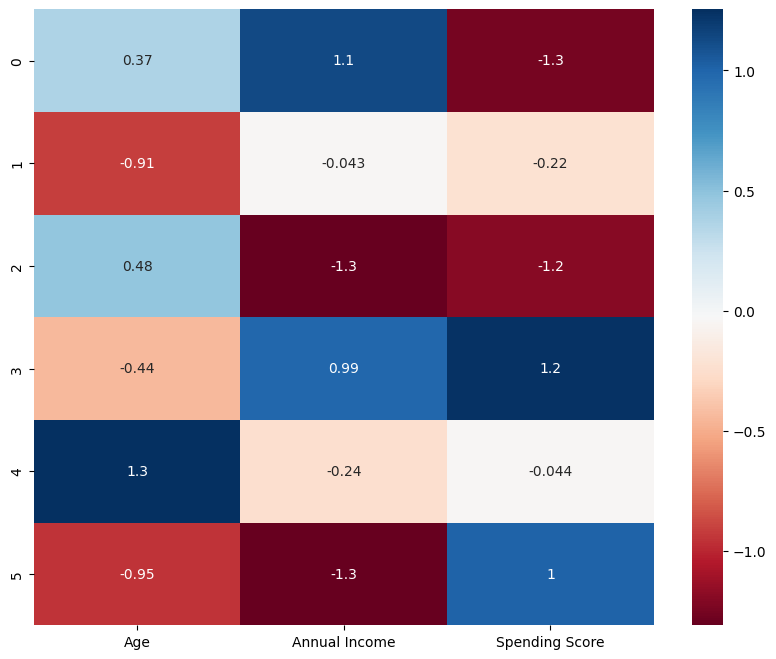

In [56]:
#Create a heat map of the cluster centers
plt.figure(figsize=(10,8))
clus_cen6_3dim = pd.DataFrame(kmeans6_3dim.cluster_centers_, columns=X_3dim_scaled.columns)
sns.heatmap(clus_cen6_3dim, cmap='RdBu', annot=True);

In [61]:
#Add cluster label to dataframe
clean_df['kmeans6_3dim_labels'] = kmeans6_3dim.labels_
#Change type to category
clean_df['kmeans6_3dim_labels'] = clean_df['kmeans6_3dim_labels'].astype('category')
#Create boxplot visual to see compare each cluster in each feature


In [62]:


#3D scatterplot to show all clusters
fig = px.scatter_3d(clean_df,
                    x='Annual Income',
                    y='Spending Score',
                    z='Age',
                    color='kmeans6_3dim_labels',
                    labels={"kmeans6_3dim_labels": "Cluster"},
                    category_orders={'kmeans6_3dim_labels':[0,1,2,3,4,5]})
fig.show()


Here we complete our basic Market Segmentation Basic Project that give a good overview of the system.